
![EDM DJ on Scene](http://dailytrojan.com/wp-content/uploads/2013/04/web_dance.jpg)

# Lyrics Generator fro EDM (Electric Dance Music) - First Step

<font color = 'b'>I am always a fan for EDM(Electric Dance Music) not only because it is versatile, it is dynamic and it is also novel and changes itself to different styles. It can be as dark as rock or as smooth as jazz. But the most interesting part of the EDM is that it can pick up a tons of topics like love, friendship or those are moody like anxiety, sadness. And also because of this music type, it is also easier to made up some lyrics out of nowhere as long as they are catchy and not to worrying about if it is really make sense or not. Of course it makes it a easy target for criticism that a lot of haters believe this type of music is so 'cheap' that it is not considered to be a serious type of music. But I find they are charming because it shows for one part, it leads us a way to find emotion simulator for people's brain and also prospect a way of artificial emotions that can be replicated once we can find a pattern. </font>


<font color = 'blue'> Therefore, what I foresee this project (Project one) is to do a kickstarter for my lyrics generator for EDM. Ideally, my user for this lyrics generator will receive a bunch of lyrics proposal by the machine depends on what they have in input. Such as what type of music, what mood it is, or what topics they are looking for. And they can also do a random pick and select yes or no ideally because the machine will remembers not to recommend this type of music because it is rejected. It is not a easy task and I will foresee to undertake this part for at least one month. But we can start something easy and enough for this project requirements. Which is a simple exploratory analysis on the data I am given. Which is a lyrics data which I have downloaded from github. </font>

## Part 1: Exploratory Analysis

### 1.1 Environment Setup

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import string
import umap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA

### 1.2 Data Exploration

In [15]:
# data are preprocessed in the text_preprocessing file in the starter kit
data = pyreadr.read_r('..\output\processed_lyrics.rData')

In [110]:
# Displayed what would the data looks like
df = data['dt_lyrics']
df.head()

,song,year,artist,genre,lyrics,id,stemmedwords
0,when-you-were-with-me,2009.0,a,Hip-Hop,I stopped by the house we called our home\nIt ...,1,stop house call home rundown grass overgrown s...
1,careless-whisper,2009.0,a,Hip-Hop,I feel so unsure\nAs I take your hand and lead...,2,unsure hand lead dance floor music die eyes ca...
2,2-59,2007.0,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,3,mark sunday football boots pitch people gamble...
3,power-of-desire,2007.0,a,Hip-Hop,[Chris:] Fallin' for a fantasy\nI threw away m...,4,chris fallin fantasy threw destiny stop feelin...
4,you-re-not-in-love,2007.0,a,Hip-Hop,something in the way we touch\nyou hold my han...,5,touch hold hand hold somethings change somethi...


And then we want to know some features of the lyrics on different types of music. Even though I am interested in EDM, but it is worth while to learn what patterns can we find in different kinds of music. Some thing I want to know for sure:

- What is the length (word count) for each type of genre
- How often should we pause in the lyrics (because otherwise it will to be too long to sing)
- Also I want to know what is the most popular words popping up for different genre of the songs. 

To know the answers, we need to look closer in the data.

In [20]:
df.genre.unique()

array(['Hip-Hop', 'Other', 'Pop', 'Metal', 'Rock', 'Country', 'Indie',
       'Jazz', 'Not Available', 'Electronic', 'R&B', 'Folk'], dtype=object)

So we generally have 11 genres except the on with 'Not Available'. We will still count 12 genres because the one we left off is mainly made up of those that are hard to be categorized to the main audience. 

In [41]:
# What is the length for each type of genre
df2 = df.copy()
df2['len_lyrics'] = df2['lyrics'].apply(lambda x: len(x))
df2.groupby('genre')['len_lyrics'].mean()

genre
Country           942.666711
Electronic       1013.330014
Folk             1120.023346
Hip-Hop          2667.507580
Indie             974.480273
Jazz              832.949539
Metal             988.706834
Not Available    1119.211128
Other            1288.061224
Pop              1242.849067
R&B              1147.438362
Rock              999.147490
Name: len_lyrics, dtype: float64

What do we see in this data? Well, the EDM music which is labeled as electronic is generally shorter than folk, hip-hop, other and pop, even R&b but longer than Metal, Rock, Indie, Jazz and Country. In part it is because EDM are not something that are very expressive and in part it relies so much on the music itself rather than 'words'. However, lyrics do help the EDM to produce some moody vibes and also bring some themes to the music. Let's further see the punctuation in these music. 

In [69]:
def punctCountPct(lyrics):
    res = sum([1 for w in lyrics if w in string.punctuation])
    return round(res/(len(lyrics) - lyrics.count(' ')),3)*100

In [71]:
df2['punct_lyrics'] = df2['lyrics'].apply(lambda x: punctCountPct(x))
df2.groupby('genre')['punct_lyrics'].mean()

genre
Country          2.974038
Electronic       3.553236
Folk             3.065564
Hip-Hop          4.601853
Indie            3.052428
Jazz             3.571397
Metal            2.795827
Not Available    3.835789
Other            3.862585
Pop              3.616393
R&B              4.226265
Rock             3.391561
Name: punct_lyrics, dtype: float64

Data shows the hip-hop really pause a lot partly because they are also length and you have to rap fast. But our target shows that Electronic music should also have some moderate amount of pause to make it suitable for the music. We should keep this trend in mind since it is also makes the music sounds a lot different with these lyrics.

Now we are narrowing down to EDM analysis instead of a general ones because our target is the EDM.

In [75]:
# NUM of words considered: 30

EDM = df2.loc[df2['genre']== 'Electronic']

In [77]:
EDM.head()

,song,year,artist,genre,lyrics,id,stemmedwords,len_lyrics,punct_lyrics
3203,release,2015.0,afro-celt-sound-system,Electronic,Don't argue amongst yourselves\nBecause of the...,3204,argue loss sit argue loss havent body reach yo...,619,2.7
3204,persistence-of-memory,2015.0,afro-celt-sound-system,Electronic,When I'm travelling far from home\nOn the whit...,3205,travel home white horizon youre dream overtake...,537,5.1
3205,rise-above-it,2015.0,afro-celt-sound-system,Electronic,Crackin' walls inside my head\nWith a bottle f...,3206,crackin wall inside head bottle rain promise c...,1063,1.3
3206,when-you-re-falling,2015.0,afro-celt-sound-system,Electronic,"Everyday, you crawl into the night\nA fallen a...",3207,everyday crawl night fallen angel wings set al...,1119,3.6
3207,be-with-you,2013.0,afrojack,Electronic,It's like you're moving in slow motion\nThat's...,3208,youre move slow motion mind id lifetime devoti...,1077,1.1


In [89]:
# I want to look at the stemmed words because I want to avoid to see repeated words.
k = 30
freq= Counter(word for words in EDM['stemmedwords'].str.split() for word in words)
print('Show the most frequent words in my EDM corpus: \n', freq.most_common(30))

Show the most frequent words in my EDM corpus: 
 [('love', 4865), ('time', 2259), ('youre', 2059), ('world', 1582), ('baby', 1542), ('night', 1447), ('ill', 1363), ('life', 1353), ('heart', 1343), ('day', 1245), ('ive', 1050), ('stop', 971), ('eyes', 957), ('light', 951), ('feeling', 939), ('dance', 909), ('hold', 892), ('waiting', 863), ('girl', 825), ('live', 776), ('mind', 747), ('dream', 734), ('run', 733), ('tonight', 710), ('move', 701), ('fall', 695), ('free', 658), ('hand', 640), ('call', 639), ('leave', 634)]


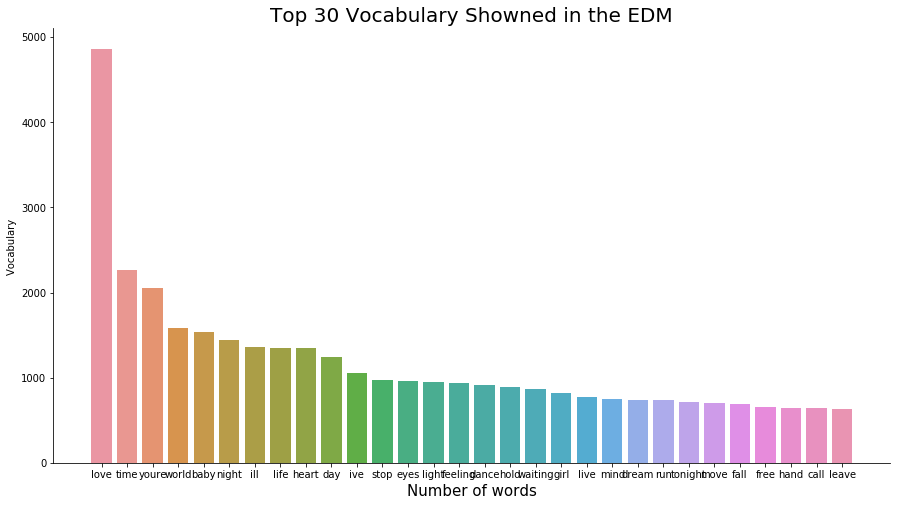

In [93]:
freq_words = pd.DataFrame(freq.most_common(30), columns = ['Vocab','Count'])
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x="Vocab", y="Count", data=freq_words)
plt.ylabel("Vocabulary ")
plt.xlabel('Number of words', fontsize=15)
plt.title('Top 30 Vocabulary Showned in the EDM', fontsize=20)
sns.despine()
plt.savefig('Top 30 Vocabulary Showned in the EDM.png')
plt.plot();

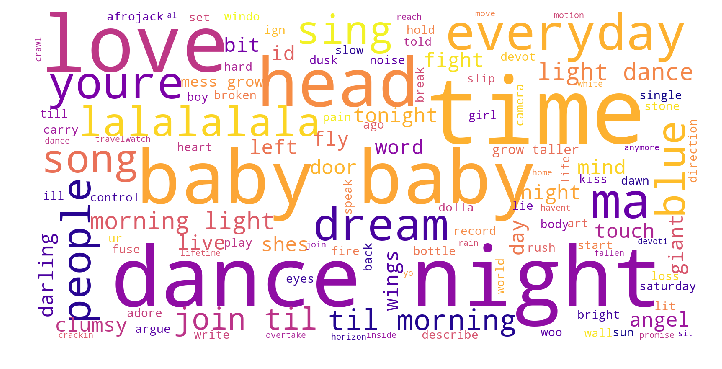

In [109]:
# We can also display the wordclouds to see visualize it a bit better
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=120,
        max_font_size=55, 
        scale=4,
        colormap = 'plasma'
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(EDM['stemmedwords'])

So we see that the most words the EDM artists are using right now is love, youre, baby, life, which is conveying some positive mood, but also some negative words are also showing up like fall, stop and leave. So we want to know more on the topic chosen with out too much of the prepabel process: how the data will naturaly display for these topics. Therefore, we will use one method in topic modelling called LDA(Latent Dirichlet Allocation). 

## 2. Topic Modelling

### 2.1 LDA

In this part, It feels like a sound idea if we are capable of making the topics as detailed as possible because we are not looking at general grasp of a topic, but rather a very detailed and specific genre. Therefore, I first look at 10 of this topic and summarize what are the general topic I have observed and then I am making 30 topics for EDM and to have a better how the lyrics for EDM is composed. Therefore the topic I will choose is about 30 and I am using tfidf to tokenized for further processing.


In [115]:
# We first generally feels what the songs are like

tfidf_vect = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.9)
X_tfidf = tfidf_vect.fit_transform(EDM['stemmedwords']) 
k_topics = 10
lda = LDA(n_components=k_topics, max_iter=10, learning_method='online', random_state=6666)
lda.fit(X_tfidf)
tfidf_features = tfidf_vect.get_feature_names()
top_k = 20
LDA_dict = dict()

for i in range(0,k_topics):
    topic = pd.DataFrame(data={'word':tfidf_features, 'weight':lda.components_[i]})
    sorted_topic = topic.sort_values('weight', ascending=False).head(20)
    LDA_dict[i+1] = list(sorted_topic['word'])

pd.DataFrame(LDA_dict)

,1,2,3,4,5,6,7,8,9,10
0,hero,riot,radio,huh,ohh,daddy,uh,love,bit,dance
1,nah,teenage,pussy,ear,ohhh,emotion,funk,time,america,rock
2,position,atari,love,whisper,dust,style,lift,youre,desert,stop
3,vibrations,destroy,save,babe,somethings,whos,pump,baby,bee,shake
4,everyday,universe,reality,fade,air,drunk,party,ill,tonight,mi
5,light,steam,sound,sweet,bass,proud,record,life,takin,ah
6,praise,bang,baby,arms,gon,mom,love,day,hold,feeling
7,spot,society,day,lost,tall,helps,play,world,refuse,di
8,remember,exist,straight,sea,original,stronger,business,heart,spine,dem
9,power,culture,alive,hand,someday,harder,experience,night,sick,body


Clearly we see that the topics are distributed in several topics:

- hero, position... related to **Positions & Power**
- riot, teenager... related to **Rebels**
- radio, love ... related  to **Enjoyment**
- wisper, fade ... related to **Emotions(Weaker)**
- dust, somethings... related to **Abstract**
- dance,rock ... related to **Movement**

In [116]:
tfidf_vect = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.9)
X_tfidf = tfidf_vect.fit_transform(EDM['stemmedwords']) 
k_topics = 40
lda = LDA(n_components=k_topics, max_iter=10, learning_method='online', random_state=6666)
lda.fit(X_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=40, n_jobs=None,
                          perp_tol=0.1, random_state=6666,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [117]:
tfidf_features = tfidf_vect.get_feature_names()
top_k = 20
LDA_dict = dict()

for i in range(0,k_topics):
    topic = pd.DataFrame(data={'word':tfidf_features, 'weight':lda.components_[i]})
    sorted_topic = topic.sort_values('weight', ascending=False).head(5)
    LDA_dict[i+1] = list(sorted_topic['word'])

pd.DataFrame(LDA_dict)

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
0,rock,city,kill,fade,lucky,conscious,jump,ohhh,radio,dust,...,hes,huh,someday,sing,stars,bass,fade,destroy,imma,faster
1,mi,people,talkin,shout,strike,shot,future,tall,bee,steam,...,whoa,lay,late,sleep,mission,wild,despair,ohh,roof,weve
2,di,drive,atari,joy,drunk,happy,death,feet,finish,watch,...,bells,love,youll,hear,count,boy,sight,universe,loud,day
3,desert,talk,teenage,smile,band,pain,cool,build,blood,doctor,...,horse,hurt,love,anytime,escape,youre,stop,culture,tears,perfect
4,bigger,sleep,youll,sea,anymore,shut,sick,swear,didnt,shoes,...,waiting,late,loss,lullaby,reach,dear,bitch,travel,shade,count


### 2.2 Topic Modelling using LSA

We can also look at other models when performing LSA. Here is the results by using SVM on this regard.

In [132]:
# SVD represent documents and terms in vectors 
vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(EDM['stemmedwords'])

svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X_tfidf)

len(svd_model.components_)

terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": \t")
    print()
    for t in sorted_terms:
        print(t[0])


Topic 0: 	

stop
bit
sad
question
flow
sound
trip
Topic 1: 	

stop
bit
stuff
bird
sunday
situation
brown
Topic 2: 	

bit
fit
original
clean
charge
sad
mmm
Topic 3: 	

fit
lifetime
trip
sparkle
waste
champion
charge
Topic 4: 	

heart
sparkle
bit
keeping
trip
original
king
Topic 5: 	

sound
fit
original
spirit
stop
toes
wet
Topic 6: 	

fit
question
clean
repeat
original
pride
charge
Topic 7: 	

lifetime
sad
original
radio
sound
pride
spirit
Topic 8: 	

lifetime
bit
champion
flow
set
mmm
girl
Topic 9: 	

sound
set
clean
heart
spirit
pure
keeping
Topic 10: 	

set
flow
clean
retox
run
original
realize
Topic 11: 	

original
trip
flow
clean
heart
sad
bite
Topic 12: 	

flow
sound
fit
bit
repeat
radio
spirit
Topic 13: 	

set
trip
repeat
fit
sparkle
mmm
retox
Topic 14: 	

fit
champion
trip
keeping
run
set
voice
Topic 15: 	

repeat
original
question
fit
sound
run
clean
Topic 16: 	

question
original
flaws
trip
clean
sparkle
spent
Topic 17: 	

heart
repeat
pussy
fit
soul
disappear
scream
Topic 18:

### Conclusion:

What can we get out of the preliminary analysis from the data if we want to be a great EDM lyrics builder?

- Moderate amount of word length to start with.
- We need the punctuation to be around 3.5%.
- For the spirits, we need to have chosen words like what is suggested from the LDA results in order to match up with the theme.

My next step will involve implementation of neural networks to build actual lyrics builder. Stay Tuned.